<a href="https://colab.research.google.com/github/cseybold/SmearScore/blob/main/SmearScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import csv
import os
import pathlib
import math

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import imutils

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Activation, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing

from sklearn.metrics import confusion_matrix

import itertools

In [ ]:
#upload data here
data_upload = files.upload()
spreadsheet = list(data_upload.keys())[0]

Saving ganscanslidescoresheet.csv to ganscanslidescoresheet.csv


In [ ]:
#upload image here
scan_upload = files.upload()
image_scan = list(scan_upload.keys())[0]

Saving FirstOfTheStitchesBR1141a.png to FirstOfTheStitchesBR1141a.png


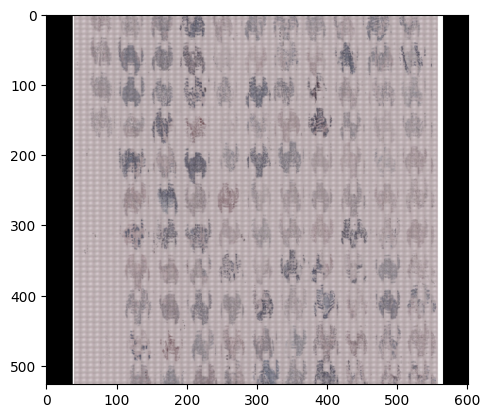

In [ ]:
original_image = Image.open(image_scan)
rotated_image1 = original_image.rotate(270)
rotated_image1.show()

rit = cv2.imread(image_scan)
Rotated_image = imutils.rotate(rit, angle=270)

plt.figure()
plt.imshow(Rotated_image)
plt.show()  # display it

**Split image in cell below (for testing purposes)**

In [ ]:
from PIL import Image

def split_image_vertically(image_path, num_splits, output_folder):

    original_image = Image.open(image_path)

    if original_image.mode == 'RGBA':
        original_image = original_image.convert('RGB')

    width, height = original_image.size
    split_width = width // num_splits

    os.makedirs(output_folder, exist_ok=True)

    split_images = []

    for i in range(num_splits):
        left = i * split_width
        right = (i + 1) * split_width if i < num_splits - 1 else width

        split_image = original_image.crop((left, 0, right, height))

        split_image_path = os.path.join(output_folder, f'split_{i+1}.jpg')
        split_image.save(split_image_path)

        split_images.append(split_image_path)

    return split_images

image_path = image_scan
output_folder = 'im_split'
num_splits = 3  # Set the number of times you want to split the image here

split_images = split_image_vertically(image_path, num_splits, output_folder)


**Put that baby right back together**

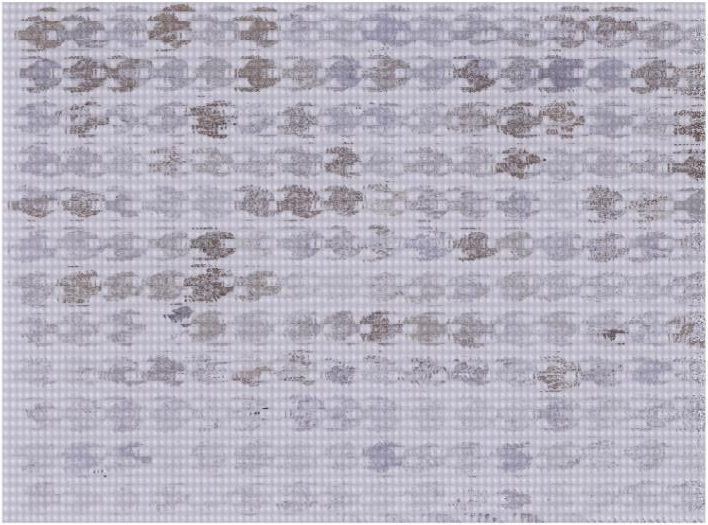

In [ ]:
image_dir = '/content/im_split'

image_files = sorted(os.listdir(image_dir))

images = [cv2.imread(os.path.join(image_dir, f)) for f in image_files]

images_rotated = [cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) for image in images]

# Resize images to have the same height
min_height = min(image.shape[0] for image in images_rotated)
images_resized = [image[:min_height, :] for image in images_rotated]

# Concatenate images vertically
result = np.concatenate(images_resized, axis=0)

cv2_imshow(result)

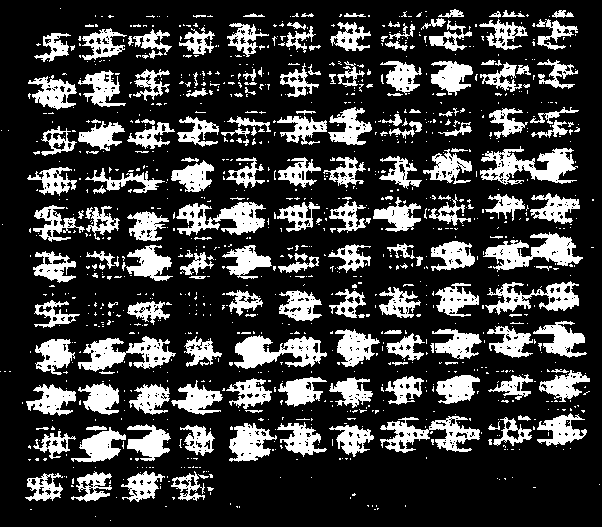

In [ ]:
#load image with cv2
image = cv2.imread(image_scan)

#convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#black and white filter
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
cv2_imshow(bin_img)

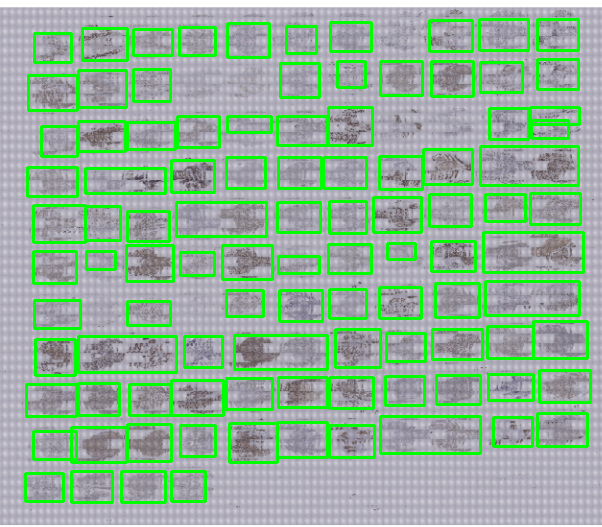

In [ ]:
contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_rectangles = image.copy()

min_contour_area = 100  # Adjustable threshold

box_count = 0
coordinates_list = []

for i, contour in enumerate(contours):
  area = cv2.contourArea(contour)
  if area > min_contour_area:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

    contour_image = image[y:y + h, x:x + w]

    box_count += 1
    coordinates_list.append((x, y, w, h))


cv2_imshow(image_with_rectangles)

Enter #rows: 11
Enter #columns: 11
Enter slide id: BR1141a


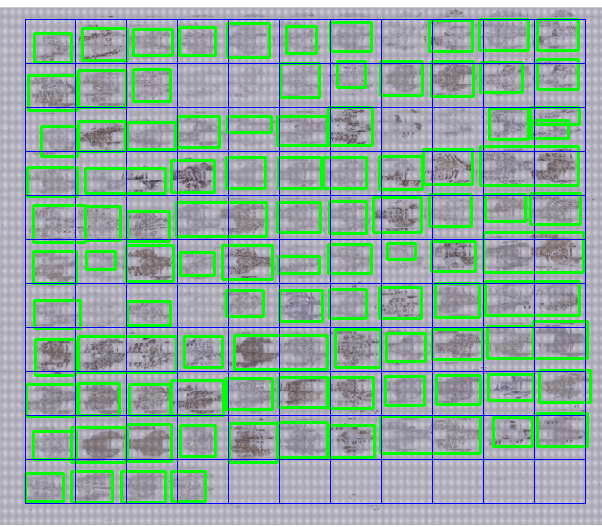

In [ ]:
# Dimension of grid (automate this / get from website?)
grid_rows = int(input("Enter #rows: "))
grid_columns = int(input("Enter #columns: "))
slide_id = input("Enter slide id: ")

# Calculate mean of box width and height
mean_w = np.mean([coord[2] for coord in coordinates_list])
mean_h = np.mean([coord[3] for coord in coordinates_list])

# Set initial boundaries
x_min = image.shape[1]
y_min = image.shape[0]
x_max = 0
y_max = 0

# Iterate through contours to find boundaries
for coord in coordinates_list:
  x, y, _, _ = coord

  if x < x_min:
    x_min = x

  if y < y_min:
    y_min = y

  if x + mean_w > x_max:
    if x + mean_w >= image.shape[1]:
      x_max = image.shape[1]
    else:
      x_max = x + mean_w

  if y + mean_h > y_max:
    if y + mean_h >= image.shape[0]:
      y_max = image.shape[0]
    else:
      y_max = y + mean_h

x_step = (x_max - x_min) / grid_columns
y_step = (y_max - y_min) / grid_rows

for i in range(grid_rows):
    for j in range(grid_columns):
      x_start = int(x_min + j * x_step)
      y_start = int(y_min + i * y_step)
      x_end = min(int(x_min + (j + 1) * x_step), image.shape[1])
      y_end = min(int(y_min + (i + 1) * y_step), image.shape[0])
      cv2.rectangle(image_with_rectangles, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)


cv2_imshow(image_with_rectangles)

output_directory = "grid_images"
sub_dirs = ['0', '1', '2', '3']
for x in sub_dirs:
  if not os.path.exists(f"{output_directory}/{x}"):
    os.makedirs(f"{output_directory}/{x}")

# Open the CSV file
with open(spreadsheet, "r") as f:
  reader = csv.reader(f)
  for i in range(grid_rows):
    for j in range(grid_columns):
      x_start = int(x_min + j * x_step)
      y_start = int(y_min + i * y_step)
      x_end = min(int(x_min + (j + 1) * x_step), image.shape[1])
      y_end = min(int(y_min + (i + 1) * y_step), image.shape[0])

      cv2.rectangle(image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

      #match ids up to image
      core_id = f"{chr(65+i)}{j+1}"
      row_found = False
      f.seek(0)
      for row in reader:
        if row[1] == slide_id and row[2] == core_id:
          score = row[7]
          row_found = True
          break
      if not row_found:
        score = "X"

      grid_image = image[y_start:y_end, x_start:x_end]


      # Check the score and save the image in the corresponding directory
      if score == "0":
        cv2.imwrite(os.path.join(f"{output_directory}/0", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "1":
        cv2.imwrite(os.path.join(f"{output_directory}/1", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "2":
        cv2.imwrite(os.path.join(f"{output_directory}/2", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "3":
        cv2.imwrite(os.path.join(f"{output_directory}/3", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      else:
        continue



Enter #rows: 11
Enter #columns: 11
Enter slide id: BR1141a


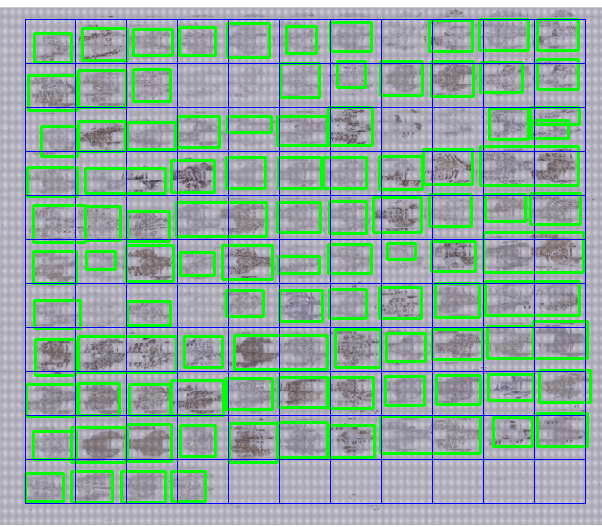

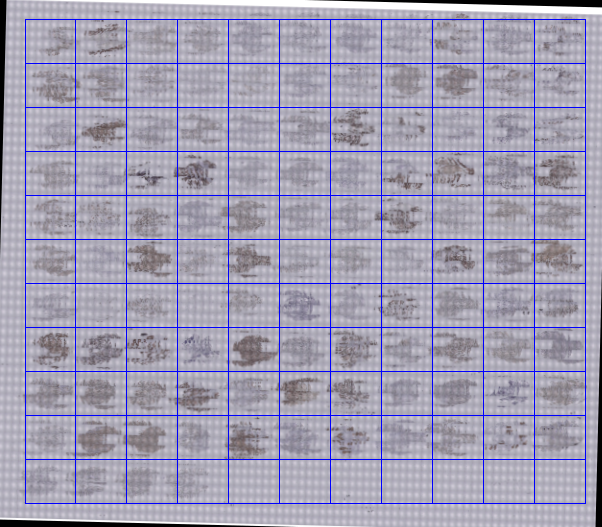

Input 0 for original or 1 for rotated: 1


In [ ]:
#NO

# Dimension of grid (automate this / get from website?)
grid_rows = int(input("Enter #rows: "))
grid_columns = int(input("Enter #columns: "))
slide_id = input("Enter slide id: ")

# Calculate mean of box width and height
mean_w = np.mean([coord[2] for coord in coordinates_list])
mean_h = np.mean([coord[3] for coord in coordinates_list])

# Set initial boundaries
x_min = image.shape[1]
y_min = image.shape[0]
x_max = 0
y_max = 0

# Iterate through contours to find boundaries
for coord in coordinates_list:
  x, y, _, _ = coord

  if x < x_min:
    x_min = x

  if y < y_min:
    y_min = y

  if x + mean_w > x_max:
    if x + mean_w >= image.shape[1]:
      x_max = image.shape[1]
    else:
      x_max = x + mean_w

  if y + mean_h > y_max:
    if y + mean_h >= image.shape[0]:
      y_max = image.shape[0]
    else:
      y_max = y + mean_h

x_step = (x_max - x_min) / grid_columns
y_step = (y_max - y_min) / grid_rows

# Find the closest contour boxes to the top-left and top-right grid points
top_left_point = (x_min, y_min)
top_right_point = (x_max, y_min)

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Initialize variables to store the closest contour boxes
closest_to_top_left = None
closest_to_top_right = None
min_dist_to_top_left = float('inf')
min_dist_to_top_right = float('inf')

for coord in coordinates_list:
    x, y, _, _ = coord

    dist_to_top_left = euclidean_distance((x, y), top_left_point)
    if dist_to_top_left < min_dist_to_top_left:
        min_dist_to_top_left = dist_to_top_left
        closest_to_top_left = coord

    dist_to_top_right = euclidean_distance((x, y), top_right_point)
    if dist_to_top_right < min_dist_to_top_right:
        min_dist_to_top_right = dist_to_top_right
        closest_to_top_right = coord

#print("Closest contour box to the top-left grid point:", closest_to_top_left)
#print("Closest contour box to the top-right grid point:", closest_to_top_right)

# Calculate the required rotation angle
y_top_left = closest_to_top_left[1]
y_top_right = closest_to_top_right[1]
delta_y = y_top_right - y_top_left
angle = math.degrees(math.atan(delta_y / (top_right_point[0] - top_left_point[0])))

# Define the center of rotation
center = (image.shape[1] // 2, image.shape[0] // 2)

# Generate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Apply the rotation to the original image
rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

for i in range(grid_rows):
    for j in range(grid_columns):
      x_start = int(x_min + j * x_step)
      y_start = int(y_min + i * y_step)
      x_end = min(int(x_min + (j + 1) * x_step), image.shape[1])
      y_end = min(int(y_min + (i + 1) * y_step), image.shape[0])
      cv2.rectangle(image_with_rectangles, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)
      cv2.rectangle(rotated_image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

cv2_imshow(image_with_rectangles)
cv2_imshow(rotated_image)

#User chooses original vs rotated image
user_choice_image = None
while user_choice_image is None:
  rotornot = int(input("Input 0 for original or 1 for rotated: "))
  if rotornot == 0:
    user_choice_image = image
    break
  elif rotornot == 1:
    user_choice_image = rotated_image
    break
  else:
    print('Invalid input: please enter 0 or 1')

#Make directories to save the cropped images (omit X?)
output_directory = "grid_images"
#sub_dirs = ['0', '1', '2', '3', 'X', ]
sub_dirs = ['0', '1', '2', '3']
for x in sub_dirs:
  if not os.path.exists(f"{output_directory}/{x}"):
    os.makedirs(f"{output_directory}/{x}")

# Open the CSV file
with open(spreadsheet, "r") as f:
  reader = csv.reader(f)
  for i in range(grid_rows):
    for j in range(grid_columns):
      x_start = int(x_min + j * x_step)
      y_start = int(y_min + i * y_step)
      x_end = min(int(x_min + (j + 1) * x_step), image.shape[1])
      y_end = min(int(y_min + (i + 1) * y_step), image.shape[0])

      cv2.rectangle(user_choice_image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

      #match ids up to image
      core_id = f"{chr(65+i)}{j+1}"
      row_found = False
      f.seek(0)
      for row in reader:
        if row[1] == slide_id and row[2] == core_id:
          score = row[7]
          row_found = True
          break
      if not row_found:
        score = "X"

      grid_image = user_choice_image[y_start:y_end, x_start:x_end]

      # Check the score and save the image in the corresponding directory
      if score == "0":
        cv2.imwrite(os.path.join(f"{output_directory}/0", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "1":
        cv2.imwrite(os.path.join(f"{output_directory}/1", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "2":
        cv2.imwrite(os.path.join(f"{output_directory}/2", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      elif score == "3":
        cv2.imwrite(os.path.join(f"{output_directory}/3", f"{slide_id}_{core_id}_{score}.png"), grid_image)
      else:
        #cv2.imwrite(os.path.join(f"{output_directory}/X", f"{slide_id}_{core_id}_{score}.png"), grid_image)
        continue



In [ ]:
batch_size = 32
img_height = int(y_step)
img_width = int(x_step)
dat_dir = '/content/grid_images'

train_ds = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 94 files belonging to 4 classes.
Using 76 files for training.
Found 94 files belonging to 4 classes.
Using 18 files for validation.


In [ ]:
model = Sequential()

res_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    pooling='max',
    classes=4,
)

model.add(res_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
epochs = 10
prediction = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/10
3/3 [==============================] - 32s 4s/step - loss: 3.7815 - accuracy: 0.3289 - val_loss: 6.0668 - val_accuracy: 0.1111
Epoch 2/10
3/3 [==============================] - 10s 3s/step - loss: 3.5691 - accuracy: 0.5526 - val_loss: 32.3224 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 10s 3s/step - loss: 1.2576 - accuracy: 0.6974 - val_loss: 143.2820 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 10s 3s/step - loss: 1.2902 - accuracy: 0.7368 - val_loss: 802.1058 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 10s 3s/step - loss: 0.6390 - accuracy: 0.7237 - val_loss: 3095.9922 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 10s 3s/step - loss: 0.6421 - accuracy: 0.8026 - val_loss: 6435.6606 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 10s 3s/step - loss: 0.5563 - accuracy: 0.7632 - val_loss: 7865.6582 - val_accuracy: 0.5000
Epoch 8/10
3/3 [====

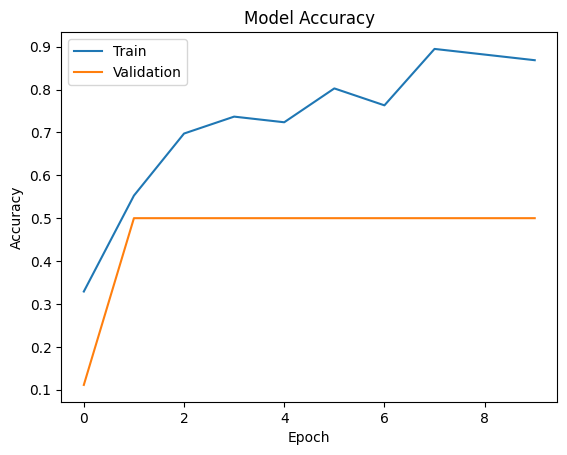

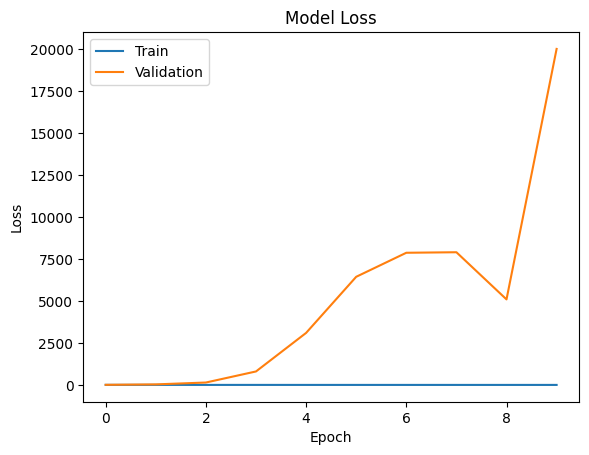

In [ ]:
# Plotting accuracy
plt.plot(prediction.history['accuracy'])
plt.plot(prediction.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(prediction.history['loss'])
plt.plot(prediction.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**data augmentation + more**

In [ ]:
trainAug = Sequential([
	preprocessing.Rescaling(scale=1.0 / 255),
	preprocessing.RandomFlip("horizontal_and_vertical"),
	preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	preprocessing.RandomRotation(0.3)
])

In [ ]:
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainLabels))
trainDS = (
	trainDS
	.shuffle(batch_size * 100)
	.batch(batch_size)
	.map(lambda x, y: (trainAug(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE)
	.prefetch(tf.data.AUTOTUNE)
)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 1s/step


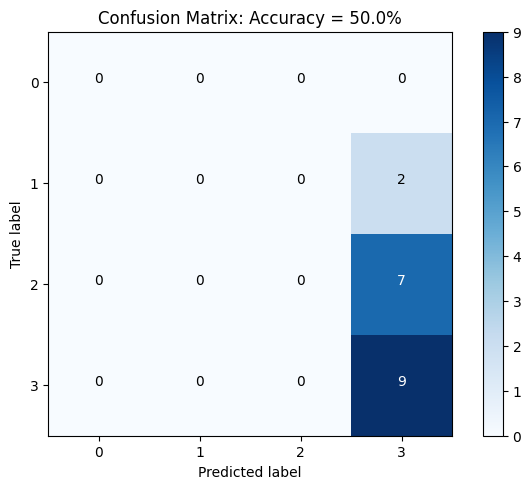

In [ ]:
y_true = np.array(correct_labels)
y_pred = np.array(predicted_labels)

class_names = [0, 1, 2, 3]

cm = confusion_matrix(y_true, y_pred, labels = class_names)

acc1 = y_pred == y_true
acc2 = (sum(acc1) / len(acc1)) * 100

# Display the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Accuracy = {acc2}%")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix for better visualization (optional)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

0.5